# **AE6102-A6**
---
1. *CPU Specifcations:*
```bash
   !lscpu | grep -e 'Model name' -e 'Thread(s) per core' -e 'Core(s) per socket' -e 'Socket(s)' -e 'MHz'
    Model Name:                         Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz
    Processor Speed:                    1.60 GHz
    Maximum Speed:                      3.90 GHz (3900.0 MHz)
    Minimum Speed:                      0.40 GHz (400.0 MHz)
    Number of Physical Cores:           4
```
2.*Cache Size:*
```
    L1 Cache(Instruction):                 128 KiB (4 instances)
    L1 Cache(Data):                        128 KiB (4 instances)
    L2 Cache:                              1 MiB (4 instances)
    L3 Cache:                              6 MiB (1 instance)
    # Each core has one L1-D, L1-I, L2 cache.
    # all 4 cores share L3 cache
```
3.*Online Specification - Intel® Core™ i5-8265U Processor (6M Cache, up to 3.90 GHz) - Intel*
```
    Model Name:                       Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz
    Max memory bandwidth:             37.5 GB/s
    GFLOPS:                           102.4 for 4 cores
```
4.*motherboard's bus frequency*
```bash
!sudo dmidecode --type memory | less
    Speed:                   2400 MT/s (Megatransfers per second)
```
5.*References (Online Specification)*:

    *   https://ark.intel.com/content/www/us/en/ark/products/149088/intel-core-i58265u-processor-6m-cache-up-to-3-90-ghz.html
    *   https://www.intel.com/content/dam/support/us/en/documents/processors/APP-for-Intel-Core-Processors.pdf



In [ ]:
!pip3 install numba numpy matplotlib

#### Memory Bandwidth vs N

Theoretical max memory bandwidth - 37.5GB/sec

Calculated max memory bandwidth - just above 12GB/sec

In practice the observed memory bandwidth will be less than (and is guaranteed not to exceed) the advertised bandwidth. There are many factors affect memory bandwidth such as accessing pattern of benchmark, operating conditions and workload. Also my machine is old and dram refresh rate slowly degrade over time.

*Graph Generated on my machine*

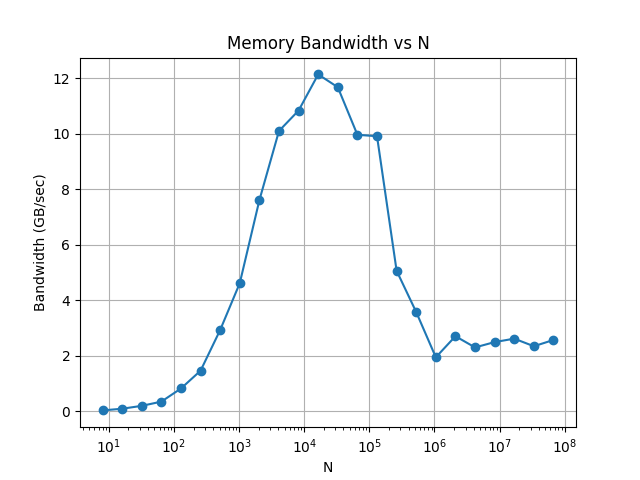

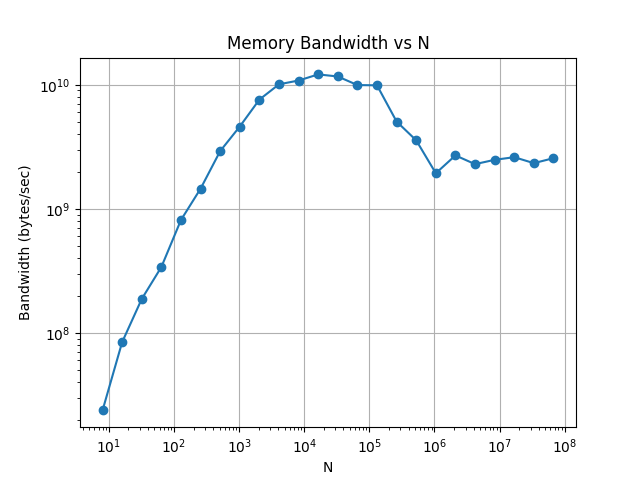

In [ ]:
import numpy as np
from numba import njit
import time
import matplotlib.pyplot as plt

In [ ]:
def make_data(n):
    x = np.linspace(0, 2*np.pi, n)
    a, b = np.random.random((2, n))
    y = np.zeros_like(x)
    return y, x, a, b

In [ ]:
@njit
def axpb(y, x, a, b):
    for i in range(y.shape[0]):
        y[i] = a[i]*x[i] + b[i]

In [ ]:
# warmup jit
y, x, a, b = make_data(1000)
axpb(y, x, a, b)
# benchmark
lst = [pow(2, i) for i in range(3, 27)]
bandwidth_list = []
for n in lst:
    y, x, a, b = make_data(n)
    s = time.perf_counter()
    axpb(y, x, a, b)
    e = time.perf_counter()
    elapsed = e - s
    bandwidth = ((n * 8) / elapsed)
    bandwidth_list.append(bandwidth)
plt.plot(lst, bandwidth_list, 'o-')
plt.xscale('log')
plt.title('Memory Bandwidth vs N')
plt.xlabel('N')
plt.yscale('log')
plt.ylabel('Bandwidth (bytes/sec)')
plt.grid()
plt.show()

In [ ]:
bandwidth_list_gb = [i/1e9 for i in bandwidth_list]
plt.plot(lst, bandwidth_list_gb, 'o-')
plt.xscale('log')
plt.title('Memory Bandwidth vs N')
plt.xlabel('N')
plt.ylabel('Bandwidth (GB/sec)')
plt.grid()
plt.show()

##### GFLOPS vs N
*Graph generated on my machine*

Glops : 102.4 (Cumulative) - specified in Intel sheet

Actual gflops is less than theoretical value because of various reason. Latency of cache, dram increases over time of machine. Theoretical numbers usually ignore some of the actual inefficiencies, such as memory access delay, register conflicts, address generation delays, jump mis predictions, and more. And of course real world code is almost never fully optimized. Also depend on benchmark.

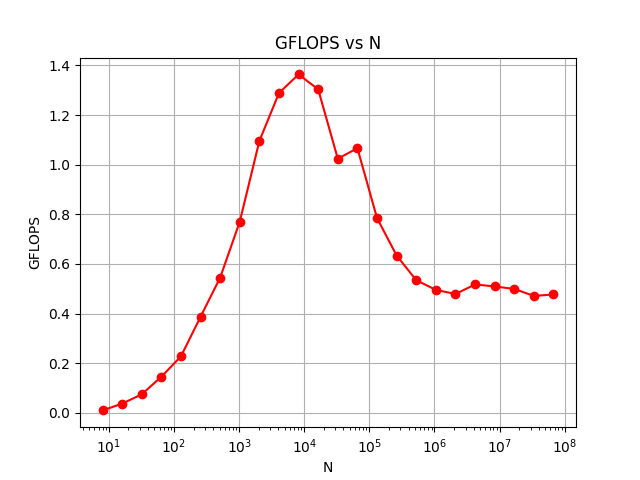

In [ ]:
def gflops_count(N):
    a = np.random.rand(N).astype(np.float64)
    b = np.random.rand(N).astype(np.float64)
    x = np.random.rand(N).astype(np.float64)
    y = np.empty(N, dtype=np.float64)
    start_time = time.perf_counter()
    y = ((a*a*b + a*x*x + b*x*b - y*a*b) + ((b*x*y + a*b)*(x*b + b*a)*(b - a*y)*(a*b - x*y)))*(a*x + b)*(a + b)
    end_time =  time.perf_counter()
    time_taken = end_time - start_time
    # 32 flops per loop * N loops 
    gflops = ((32 * N) / time_taken) / 1e9 
    return gflops

In [ ]:
lst = [pow(2, i) for i in range(3, 27)]
gflops_list = [gflops_count(N) for N in lst]
plt.plot(lst, gflops_list, 'o-', color='r')
plt.xscale('log')
plt.xlabel('N')
plt.ylabel('GFLOPS')
plt.title('GFLOPS vs N')
plt.grid()
plt.show()